In [1]:
from Helper.ml_models import MapillaryDataLoader, MapillaryTrainedModel

from functools import partial
from tqdm import tqdm
import os
import tempfile
import torch

from Helper.ml_models import * 
import json
from datetime import datetime
import ray.cloudpickle as pickle

from ray import tune, train
from ray.air.config import CheckpointConfig
from ray import tune, train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
from ray.tune import CLIReporter
import ray

from ray.tune.search.optuna import OptunaSearch
from optuna.samplers import TPESampler

import ray

2025-02-06 18:36:23.286447: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-06 18:36:23.835677: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
best_config_path = "FINAL_DATEN/best_configs_Map.json"


# Mapillary-Daten laden
mapillary_loader = MapillaryDataLoader(
    train_images_dir='Mapilarry_Vistas/training/images',
    train_annotations_dir='Mapilarry_Vistas/training_own',
    val_images_dir='Mapilarry_Vistas/validation/images',
    val_annotations_dir='Mapilarry_Vistas/validation_own'
)


In [3]:
def make_directory(model):
    dir_name = f'Hyperparameter/{model}'
    os.makedirs(dir_name, exist_ok=True)
    
    
    
modells_to_study = [
    'deeplabv3_resnet50', 
    'deeplabv3_resnet101', 
    'fcn_resnet50',
    'fcn_resnet101'
]

model = modells_to_study[0]

In [4]:
make_directory(model)

# Nutze jetzt die MapillaryTrainedModel-Klasse!
hyper_model = MapillaryTrainedModel(
    model_name=model,
    width=2048,
    height=1024,
    weights_name='',
    folder_path=f'Hyperparameter/{model}',
    start_epoch='latest'
)

Using CUDA GPU
Model loaded: deeplabv3_resnet50 | Device: cuda 
No local .pth found; initializing a new model save.
Saved Model
Successfully loaded a fresh model checkpoint.


In [5]:
hyper_model.prepare_model_training(
    dataset_train=mapillary_loader.train_dataset,
    dataset_val=mapillary_loader.val_dataset,
    batch_size=4,
    val_batch_size=1,
    shuffle=True,
    learning_rate=0.005,
    weight_decay=1e-6,
    num_workers=4,
    pin_memory=True,
    ray_tune=True,
)

Training Dataset prepared
Validation Dataset prepared


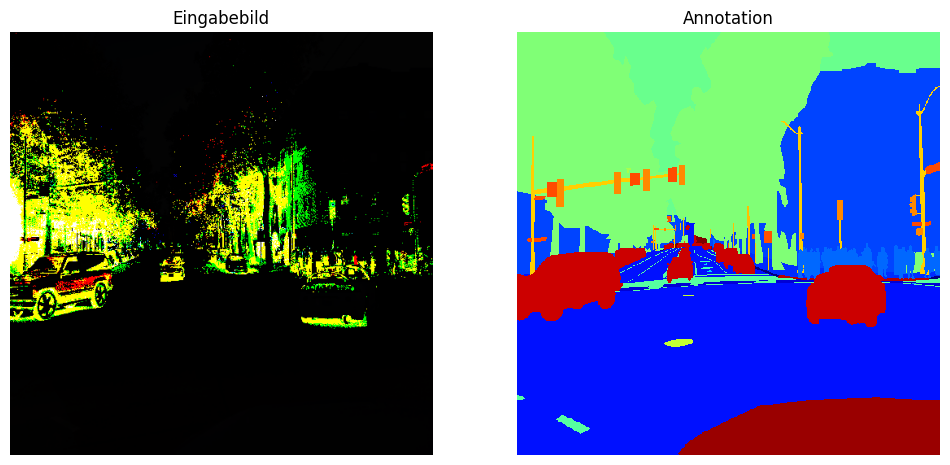

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Eine Probe aus dem Trainingsdatensatz laden
image, annotation = mapillary_loader.train_dataset[0]  # Index 0 für das erste Bild

# Falls das Bild ein Tensor ist, konvertiere es in ein numpy-Array
if isinstance(image, torch.Tensor):
    image = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

# Falls die Annotation ein Tensor ist, konvertiere es in ein numpy-Array
if isinstance(annotation, torch.Tensor):
    annotation = annotation.numpy()

# Bild anzeigen
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image.astype(np.uint8))
axes[0].set_title("Eingabebild")
axes[0].axis("off")

# Annotation anzeigen
axes[1].imshow(annotation, cmap="jet", interpolation="nearest")
axes[1].set_title("Annotation")
axes[1].axis("off")

plt.show()